# Mount Notebook to Google Drive
Upload the data, pretrianed model, figures, etc to your Google Drive, then mount this notebook to Google Drive. After that, you can access the resources freely.

Instruction: https://colab.research.google.com/notebooks/io.ipynb

Example: https://colab.research.google.com/drive/1srw_HFWQ2SMgmWIawucXfusGzrj1_U0q

Video: https://www.youtube.com/watch?v=zc8g8lGcwQU

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Introduction
Andrew Jeffers, Haesung Jeong <br>
GitHub Repo Link: https://github.com/ajeffers999/CS598-Project

The paper explores an approach to determine how a patient's family members' medical history influences their disease risk. This is a meaningful problem because it could help inform patients about their risk for certain diseases based on relative and family information. Utlizing family medical history for predicting a patient's disease risk is also complicated by a variety of genetic, environmental, and lifestyle factors.

This paper proposes a novel solution to this problem by utilizing a graph-based deep learning approach for learning representations of family member's influence on patient's disease risk. A graph based approach is a more useful and natural way of modeling the connections between family members than previous methods.

Previous works have also recognized that it is useful to include information from family members when predicting the risk of disease. However, machine learning approaches using tabular data do not model the underlying geometric structure of family history. Using a graph based approach, this structure is much more easily obtained and modeled.

The main contributions of the paper are:
  * a scalable, disease-agnostic machine learning tool making use of GNNs and LSTMs which learn representations of a patient's disease risk from family member's medical information.
  * Data which shows graph-based approaches perform better than clinically-inspired or deep learning baselines used previously.
  * Graph explanability techniques demonstrate that GNN-LSTM embeddings identify medical features which are more suitable for predicting disease risk than features identifies by an epidemiological baseline.

The researchers observed that graph-based models consistently outperformed the baseline approaches, although the best performing model between GNN and GNN-LSTM varied depending on the disease in question. Cancers typically performed better on the GNN model, which the researchers believe is due to cancers generally being less hereditary than other diseases.

In [ ]:
# code comment is used as inline annotations for your coding

# Scope of Reproducibility:

List hypotheses from the paper you will test and the corresponding experiments you will run.


1.   Hypothesis 1: Graph-based approaches predict disease risk better than the baseline model.
2.   Hypothesis 2: The GNN model using GraphConv layers predicts disease risk better than the GNN model using GCN layers.


# Methodology

This methodology is the core of your project. It consists of run-able codes with necessary annotations to show the experiment you executed for testing the hypotheses.

The methodology at least contains two subsections **data** and **model** in your experiment.

# Libraries
Below are the Python libraries used to implement graph representation learning for familial relationships.

In [ ]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 9.6 MB/s eta 0:00:00


In [ ]:
# import  packages you need
import torch
import torch_geometric
import sqlite3
import pandas as pd
import numpy as np
from torch.utils.data import Dataset
from torch_geometric.loader import DataLoader
from torch_geometric.data import Dataset as GraphDataset
from torch_geometric.data import Batch
import torch_geometric.nn as gnn
import torch.nn as nn
import torch.nn.functional as F
from sklearn import metrics
from tqdm import tqdm
from random import choices
import matplotlib.pyplot as plt
import gdown

from google.colab import drive



## Data
  * Source of the data: The data is sourced from the Github repository at https://github.com/dsgelab/family-EHR-graphs. Since the paper relies on a nationwide health registry dataset that cannot be publicly shared due to privacty concerns, this dataset is designed to mimic the key properties of the actual data.
  * Statistics: This is synthetic data, which means we are able to choose the amount of data we would like to use. In this case, we are using 150000 number of rows. Out of 150000 rows, 57297 are marked as True and 92703 are marked as False
  * Data process: We are splitting the data into an 80/20 train/test split. For example, for baseline non-longitudinal data, we are only usig 39,297 rows of data. For training, we are using 31,437 rows of data andn 7860 for testing. As this is synthetic data, there is little to no cleaning required.



In [ ]:
raw_data_dir = '/content/drive/MyDrive/CS598 DLH/Project/'

class DataFetch():
    """
    Class for fetching and formatting data

    Expects a tensor list of patients encoded using the numerical node_ids

    Assumes maskfile, statfile rows are indexed in order of these node_ids (0, 1, ... num_samples)
    and they include data for both the target and graph samples (retrieve data using .iloc)

    The edgefile only needs to include data for the target samples, and is indexed
    using the node_ids (retrieve data using .loc)

    Note that the featfile has exactly one label, corresponding to the label column name in the statfile

    Note if the input is a directed graph the code converts it to an undirected graph

    Parameters:
    maskfile, featfile, statfile and edgefile are filepaths to csv files
    sqlpath is the path to the sql database
    params is a dictionary of additional parameters (obs_window_start, obs_window_end)
    """
    def __init__(self, model_type, gnn_layer, featfile, alt_featfile=None, local=False):
        feat_df = pd.read_csv(raw_data_dir + featfile)
        statfile = pd.read_csv(raw_data_dir + 'Gen3_50k_0.7_142857_statfile.csv')

        self.local = local
        self.static_features = feat_df[feat_df['type']=='static']['name'].tolist()
        self.longitudinal_features = feat_df[feat_df['type']=='longitudinal']['name'].tolist()
        self.edge_features = feat_df[feat_df['type']=='edge']['name'].tolist()
        # some gnn layers only support a single edge weight
        if gnn_layer in ['gcn', 'graphconv']: self.edge_features=['weight']
        self.label_key = feat_df[feat_df['type']=='label']['name'].tolist()[0]
        self.static_data = torch.tensor(statfile[self.static_features].values, dtype=torch.float)
        self.label_data = torch.tensor(statfile[self.label_key].to_numpy(), dtype=torch.float32)
        # if len(self.longitudinal_features)>0 and not self.local: self.conn = sqlite3.connect(sqlpath)
        # self.params = params

        if model_type in ['graph', 'graph_no_target', 'explainability']:
            # can specify a different feature set using alt_featfile
            alt_feat_df = pd.read_csv(raw_data_dir + alt_featfile)
            self.alt_static_features = alt_feat_df[alt_feat_df['type']=='static']['name'].tolist()
            self.alt_static_data = torch.tensor(statfile[self.alt_static_features].values, dtype=torch.float)

        mask_df = pd.read_csv(raw_data_dir + 'Gen3_50k_0.7_142857_maskfile.csv')
        self.id_map = dict(zip(mask_df['node_id'], mask_df['PATIENTID']))
        self.train_patient_list = torch.tensor(mask_df[mask_df['train']==0]['node_id'].to_numpy())
        self.validate_patient_list = torch.tensor(mask_df[mask_df['train']==1]['node_id'].to_numpy())
        self.test_patient_list = torch.tensor(mask_df[mask_df['train']==2]['node_id'].to_numpy())
        self.num_samples_train_minority_class = torch.sum(self.label_data[self.train_patient_list]==1).item()
        self.num_samples_train_majority_class = torch.sum(self.label_data[self.train_patient_list]==0).item()
        self.num_samples_valid_minority_class = torch.sum(self.label_data[self.validate_patient_list]==1).item()
        self.num_samples_valid_majority_class = torch.sum(self.label_data[self.validate_patient_list]==0).item()

        if model_type!='baseline':
            self.edge_df = pd.read_csv(raw_data_dir + 'Gen3_50k_0.7_142857_edgefile.csv')
            self.edge_df = self.edge_df.groupby('target_patient').agg(list)

    def get_static_data(self, patients):
        x_static = self.static_data[patients]
        y = self.label_data[patients]
        return x_static, y

    def get_alt_static_data(self, patients):
        x_static = self.alt_static_data[patients]
        return x_static

    def get_longitudinal_data(self, patients):
        if self.local:
            # return simulated data for local testing
            num_nodes = len(patients)
            num_years = self.params['obs_window_end']-self.params['obs_window_start']+1
            num_features = len(self.longitudinal_features)
            num_data = int(num_nodes*num_years*num_features*0.01)
            i = [choices(range(num_nodes),k=num_data), choices(range(num_years),k=num_data), choices(range(num_features),k=num_data)]
            v = [1]*num_data
            x_longitudinal = torch.sparse_coo_tensor(i, v, (num_nodes, num_years, num_features), dtype=torch.float32)
            x_longitudinal_dense = x_longitudinal.to_dense()
        else:
            # fetch data from SQLite database
            id_list = [self.id_map[patient.item()] for patient in patients]
            data = pd.DataFrame()
            for patient in id_list:
                command = "SELECT PATIENTID, EVENT_YEAR, ENDPOINT FROM long WHERE PATIENTID='{}'".format(patient)
                data = pd.concat([data, pd.read_sql_query(command, self.conn)])
            data = data[data['ENDPOINT'].isin(self.longitudinal_features)]

            # limit to observation window years
            data['EVENT_YEAR'] = data['EVENT_YEAR'].astype(int)
            data = data[(data['EVENT_YEAR']>=self.params['obs_window_start'])&(data['EVENT_YEAR']<=self.params['obs_window_end'])]

            # map to index positions
            node_index = dict(zip(id_list, range(len(id_list))))
            year_index = dict(zip(np.arange(self.params['obs_window_start'], self.params['obs_window_end']+1), range(self.params['obs_window_end']-self.params['obs_window_start']+1)))
            feat_index = dict(zip(self.longitudinal_features, range(len(self.longitudinal_features))))
            data['PATIENTID'] = data['PATIENTID'].map(node_index)
            data['EVENT_YEAR'] = data['EVENT_YEAR'].map(year_index)
            data['ENDPOINT'] = data['ENDPOINT'].map(feat_index)

            # create sparse tensor
            i = [data['PATIENTID'].tolist(), data['EVENT_YEAR'].tolist(), data['ENDPOINT'].tolist()]
            v = [1]*len(data)
            x_longitudinal = torch.sparse_coo_tensor(i, v, (len(node_index), len(year_index), len(feat_index)), dtype=torch.float32)
            x_longitudinal_dense = x_longitudinal.to_dense()

        return x_longitudinal_dense

    def get_relatives(self, patients):
        """Returns a list of node ids included in any of these patient graphs
        """
        return torch.tensor(list(set([i for list in self.edge_df.loc[patients]['node1'].to_list() for i in list] + [i for list in self.edge_df.loc[patients]['node2'].to_list() for i in list])))

    def construct_patient_graph(self, patient, all_relatives, all_x_static, all_y, all_x_longitudinal=None):
        """Creates a re-indexed pytorch geometric data object for the patient
        """
        # order nodes and get indices in all_relatives to retrieve feature data
        node_ordering = np.asarray(list(set(self.edge_df.loc[patient].node1 + self.edge_df.loc[patient].node2)))
        node_indices = [list(all_relatives.tolist()).index(value) for value in node_ordering]
        x_static = all_x_static[node_indices]
        y = all_y[list(all_relatives.tolist()).index(patient)] # predicting single value for each graph

        # reindex the edge indices from 0, 1, ... num_nodes
        node1 = [list(node_ordering.tolist()).index(value) for value in self.edge_df.loc[patient].node1]
        node2 = [list(node_ordering.tolist()).index(value) for value in self.edge_df.loc[patient].node2]
        edge_index = torch.tensor([node1,node2], dtype=torch.long)
        edge_weight = torch.t(torch.tensor(self.edge_df.loc[patient][self.edge_features], dtype=torch.float))

        data = torch_geometric.data.Data(x=x_static, edge_index=edge_index, y=y, edge_attr=edge_weight)
        transform = torch_geometric.transforms.ToUndirected(reduce='mean')
        data = transform(data)
        if all_x_longitudinal is not None: data.x_longitudinal = all_x_longitudinal[node_indices]
        data.target_index = torch.tensor(list(node_ordering.tolist()).index(patient))
        return data


class Data(Dataset):
    def __init__(self, patient_list, fetch_data):
        """
        Loads non-graph datasets for a given list of patients
        Returns (x_static, x_longitudinal, y) if longitudinal data included, else (x_static, y)
        """
        self.patient_list = patient_list
        self.num_target_patients = len(patient_list)
        self.fetch_data = fetch_data
        self.include_longitudinal = len(fetch_data.longitudinal_features)>0

    def __getitem__(self, patients):
        batch_patient_list = self.patient_list[patients]
        x_static, y = self.fetch_data.get_static_data(batch_patient_list)
        if self.include_longitudinal:
            x_longitudinal = self.fetch_data.get_longitudinal_data(batch_patient_list)
            return x_static, x_longitudinal, y
        else:
            return x_static, y

    def __len__(self):
        return self.num_target_patients


class GraphData(GraphDataset):
  def __init__(self, patient_list, fetch_data):
      """
      Loads a batch of multiple patient graphs
      """
      self.patient_list = patient_list
      self.num_target_patients = len(patient_list)
      self.fetch_data = fetch_data
      self.include_longitudinal = len(fetch_data.longitudinal_features)>0

  def __getitem__(self, patients):
      # returns multiple patient graphs by constructing a pytorch geometric Batch object
      batch_patient_list = self.patient_list[patients]
      data_list = []

      # it's more efficient to fetch feature data for all patients and their relatives,
      # and then split into separate graphs
      all_relatives = self.fetch_data.get_relatives(batch_patient_list)
      all_x_static, all_y = self.fetch_data.get_static_data(all_relatives)
      patient_x_static = self.fetch_data.get_alt_static_data(batch_patient_list)
      if self.include_longitudinal: all_x_longitudinal = self.fetch_data.get_longitudinal_data(all_relatives)
      else: all_x_longitudinal = None

      patient_index = 0
      for patient in batch_patient_list:
        patient_graph = self.fetch_data.construct_patient_graph(patient.item(), all_relatives, all_x_static, all_y, all_x_longitudinal)
        patient_graph.patient_x_static = patient_x_static[patient_index].reshape(1,-1)
        if self.include_longitudinal:
            patient_x_longitudinal = patient_graph.x_longitudinal[patient_graph.target_index]
            patient_graph.patient_x_longitudinal = patient_x_longitudinal[None,:,:]
        data_list.append(patient_graph)
        patient_index += 1

      batch_data = Batch.from_data_list(data_list)
      return batch_data

  def __len__(self):
      return self.num_target_patients

In [ ]:
def get_data_and_loader(patient_list, fetch_data, model_type, batch_size, shuffle=True):
    """
    Parameters:
    patient_list: list of patients (target samples) to load data for
    fetch_data: the data object
    params: dictionary of other parameters
    shuffle: samples in random order if true
    """
    if model_type == 'baseline':
        dataset = Data(patient_list, fetch_data)
    elif model_type in ['graph', 'graph_no_target', 'explainability']:
        dataset = GraphData(patient_list, fetch_data)

    if shuffle:
        sample_order = torch.utils.data.sampler.RandomSampler(dataset)
    else:
        sample_order = torch.utils.data.sampler.SequentialSampler(dataset)

    sampler = torch.utils.data.sampler.BatchSampler(
        sample_order,
        batch_size=batch_size,
        drop_last=False)

    loader = DataLoader(dataset, sampler=sampler, num_workers=1)
    return dataset, loader



##   Model
The model includes the model definition which usually is a class, model training, and other necessary parts.

* Training Objectives: We are using the Adam optimizer and the WeightedBCELoss loss function. Our dropout rate is 0.5 and our learning rate is 0.001.

  ### Baseline Model
  * Model architecture: The Baseline Model has three linear layers, with a ReLU activation function, Sigmoid activation function, and a Dropout layer.
  * The model is not pretrained, and the training code is shown below.

  ### GNN Model
  * Model Architecture: The GNN model can be customized more than the Baseline model. There are two GNN layers in use in this model, which can be one of three types: GCN, GraphConv, or GAT. Additionally, there can be one of many types of pooling methods: target, sum, mean, etc. The model also has quite a few linear layers that is chooses between based on for different parts of the data. One final Linear layer is used to retrieve patient results, and a different final Linear layer is used to retrieve family results.
  * The model is not pretrained, and the training code is shown below.

In [ ]:
class Baseline(torch.nn.Module):
    def __init__(self, num_features_static, hidden_dim, dropout_rate):
        super().__init__()
        self.static_linear1 = nn.Linear(num_features_static, hidden_dim)
        self.static_linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.final_linear = nn.Linear(hidden_dim, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x_static):
        linear_out = self.relu(self.static_linear1(x_static))
        linear_out = self.relu(self.static_linear2(linear_out))
        linear_out = self.dropout(linear_out)
        out = self.sigmoid(self.final_linear(linear_out))
        return out

class GNN(torch.nn.Module):
    def __init__(self, num_features_static_graph, num_features_static_node, hidden_dim, gnn_layer, pooling_method, dropout_rate, ratio):
        super().__init__()
        self.pooling_method = pooling_method
        self.static_linear1 = nn.Linear(num_features_static_node, hidden_dim)
        self.static_linear2 = nn.Linear(hidden_dim, hidden_dim)

        # which gnn layer to use is specified by input argument
        if gnn_layer=='gcn':
            print("Using GCN layers")
            self.conv1 = gnn.GCNConv(num_features_static_graph, hidden_dim)
            self.conv2 = gnn.GCNConv(hidden_dim, hidden_dim)
        if gnn_layer=='graphconv':
            print("Using GraphConv layers")
            self.conv1 = gnn.GraphConv(num_features_static_graph, hidden_dim)
            self.conv2 = gnn.GraphConv(hidden_dim, hidden_dim)
        elif gnn_layer=='gat':
            print("Using GAT layers")
            self.conv1 = gnn.GATConv(num_features_static_graph, hidden_dim)
            self.conv2 = gnn.GATConv(hidden_dim, hidden_dim)

        self.pre_final_linear = nn.Linear(2*hidden_dim, hidden_dim)
        self.final_linear_com = nn.Linear(hidden_dim, 1)
        self.final_linear = nn.Linear(hidden_dim, 1)
        self.final_linear1 = nn.Linear(hidden_dim, 1)
        self.final_linear2 = nn.Linear(hidden_dim, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

        self.TopKpool = gnn.TopKPooling(hidden_dim, ratio=ratio)
        self.SAGpool = gnn.SAGPooling(hidden_dim, ratio=ratio)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x_static_node, x_static_graph, edge_index, edge_weight, batch, target_index):
        # patient part of the network
        linear_out = self.relu(self.static_linear1(x_static_node))
        linear_out = self.relu(self.static_linear2(linear_out))
        patient_out = self.dropout(linear_out)

        # family part of the network
        gnn_out = self.relu(self.conv1(x_static_graph, edge_index, edge_weight))
        gnn_out = self.relu(self.conv2(gnn_out, edge_index, edge_weight))

        if self.pooling_method=='target':
            out = gnn_out[target_index] # instead of pooling, use the target node embedding
        elif self.pooling_method=='sum':
            out = gnn.global_add_pool(gnn_out, batch)
        elif self.pooling_method=='mean':
            out = gnn.global_mean_pool(gnn_out, batch)
        elif self.pooling_method=='topkpool_sum':
            out, pool_edge_index, pool_edge_attr, pool_batch, _, _ = self.TopKpool(gnn_out, edge_index, edge_weight, batch)
            out = gnn.global_add_pool(out, pool_batch)
        elif self.pooling_method=='topkpool_mean':
            out, pool_edge_index, pool_edge_attr, pool_batch, _, _ = self.TopKpool(gnn_out, edge_index, edge_weight, batch)
            out = gnn.global_mean_pool(out, pool_batch)
        elif self.pooling_method=='sagpool_sum':
            out, pool_edge_index, pool_edge_attr, pool_batch, _, _ = self.SAGpool(gnn_out, edge_index, edge_weight, batch)
            out = gnn.global_add_pool(out, pool_batch)
        elif self.pooling_method=='sagpool_mean':
            out, pool_edge_index, pool_edge_attr, pool_batch, _, _ = self.SAGpool(gnn_out, edge_index, edge_weight, batch)
            out = gnn.global_mean_pool(out, pool_batch)

        family_out = self.dropout(out)

        # combined part of network (classifiation output)
        out = torch.cat((patient_out, family_out), 1)
        out = self.relu(self.pre_final_linear(out))
        out = self.sigmoid(self.final_linear_com(out))
        # separate output heads for different parts of the network (for loss calculations)
        patient_out = self.sigmoid(self.final_linear1(patient_out))
        family_out = self.sigmoid(self.final_linear2(family_out))
        return out, patient_out, family_out

# Custom Loss function
Class imbalance arises because the models are predicting diseases with prevalence < 10% in the selected cohorts. The authors of the paper alleviate this by using class-weighted loss functions, sampling strategies designed for imbalanced classification, methods to prevent overfitting, and careful choice and interpretation of evaluation metrics (Wharrie, Sophie, et al.).


In [ ]:
class WeightedBCELoss(torch.nn.Module):
    def __init__(self, num_samples_dataset, num_samples_minority_class, num_samples_majority_class):
        super(WeightedBCELoss,self).__init__()
        self.num_samples_dataset = num_samples_dataset
        self.num_samples_minority_class = num_samples_minority_class
        self.num_samples_majority_class = num_samples_majority_class

    def forward(self, y_est, y):
        weight_minority = self.num_samples_dataset / self.num_samples_minority_class
        weight_majority = self.num_samples_dataset / self.num_samples_majority_class
        class_weights = torch.tensor([[weight_minority] if i==1 else [weight_majority] for i in y])
        bce_loss = torch.nn.BCELoss(weight=class_weights)
        weighted_bce_loss = bce_loss(y_est, y)
        return weighted_bce_loss


In [ ]:
def brier_skill_score(actual_y, predicted_prob_y):
    e = sum(actual_y) / len(actual_y)
    bs_ref = sum((e-actual_y)**2) / len(actual_y)
    bs = sum((predicted_prob_y-actual_y)**2) / len(actual_y)
    bss = 1 - bs / bs_ref
    return bss

def calculate_metrics(actual_y, predicted_y, predicted_prob_y):
    auc_roc = metrics.roc_auc_score(actual_y, predicted_prob_y)
    precision, recall, thresholds = metrics.precision_recall_curve(actual_y, predicted_prob_y)
    auc_prc = metrics.auc(recall, precision)
    mcc = metrics.matthews_corrcoef(actual_y, predicted_y)
    tn, fp, fn, tp = metrics.confusion_matrix(actual_y, predicted_y).ravel()
    ts = tp / (tp + fn + fp)
    recall = tp / (tp + fn)
    f1 = (2*tp) / (2*tp + fp + fn)
    bss = brier_skill_score(actual_y, predicted_prob_y)

    metric_results = {'metric_auc_roc':auc_roc, # typically reported, but can be biased for imbalanced classes
               'metric_auc_prc':auc_prc, # better suited for imbalanced classes
               'metric_f1':f1, # also should be better suited for imbalanced classes
               'metric_recall':recall, # important for medical studies, to reduce misses of positive instances
               'metric_mcc':mcc, # correlation that is suitable for imbalanced classes
               'metric_ts':ts, # suited for rare events, penalizing misclassification as the rare event (fp)
               'metric_bss':bss, # brier skill score, where higher score corresponds better calibration of predicted probabilities
               'true_negatives':tn,
               'false_positives':fp,
               'false_negatives':fn,
               'true_positives':tp}

    return metric_results

**Baseline A2 - Age, Sex, and family history MLP**

In [ ]:
model_type='baseline'
fetch_data = DataFetch(model_type=model_type, featfile='featfiles/featfile_A2.csv', gnn_layer='graphconv')
train_patient_list = fetch_data.train_patient_list
validate_patient_list = fetch_data.validate_patient_list
num_features_static = len(fetch_data.static_features)
num_samples_train_dataset = len(train_patient_list)
num_samples_valid_dataset = len(validate_patient_list)
num_samples_train_minority_class = fetch_data.num_samples_train_minority_class
num_samples_valid_minority_class = fetch_data.num_samples_valid_minority_class
num_samples_train_majority_class = fetch_data.num_samples_train_majority_class
num_samples_valid_majority_class = fetch_data.num_samples_valid_majority_class

batch_size=250
main_hidden_dim = 20
lstm_hidden_dim = 20
dropout_rate = 0.5
learning_rate = 0.001
num_batches_train = int(np.ceil(len(train_patient_list)/batch_size))
num_batches_validate = int(np.ceil(len(validate_patient_list)/batch_size))

model = Baseline(num_features_static, main_hidden_dim, dropout_rate)
loss_func = WeightedBCELoss(num_samples_train_dataset, num_samples_train_minority_class, num_samples_train_majority_class)
valid_loss_func = WeightedBCELoss(num_samples_valid_dataset, num_samples_valid_minority_class, num_samples_valid_majority_class)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_dataset, train_loader = get_data_and_loader(train_patient_list, fetch_data, model_type, batch_size)
validate_dataset, validate_loader = get_data_and_loader(validate_patient_list, fetch_data, model_type, batch_size)

print('static_data: ', len(fetch_data.static_data))
print('label data: ', len(fetch_data.label_data))
print('True label: ', fetch_data.label_data.sum().item())
print('False label: ', len(fetch_data.label_data) -fetch_data.label_data.sum().item())
print('Train dataset: ', len(train_patient_list))
print('Validate dataset: ', len(validate_patient_list))
print('Test dataset: ', len(fetch_data.test_patient_list))

static_data:  150000
label data:  150000
True label:  57297.0
False label:  92703.0
Train dataset:  27565
Validate dataset:  3872
Test dataset:  7860



**Below is the traing step used to generate the checkpoint file**

In [ ]:
# num_epoch = 10
# # model training loop: it is better to print the training/validation losses during the training
# train_losses = []
# valid_losses = []
# for i in range(num_epoch):
#   model.train()
#   epoch_train_loss = []
#   for train_batch in tqdm(train_loader, total=num_batches_train):
#     x_static, y = train_batch[0][0], train_batch[1][0].unsqueeze(1)
#     output = model(x_static)
#     model_output = {'output': output}
#     loss = loss_func(output, y)
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()
#     epoch_train_loss.append(loss.item())

#   # eval on validset
#   model.eval()
#   epoch_valid_loss = []
#   valid_output = np.array([])
#   valid_y = np.array([])
#   for valid_batch in tqdm(validate_loader, total=num_batches_validate):
#     x_static, y = valid_batch[0][0], valid_batch[1][0].unsqueeze(1)
#     output = model(x_static)
#     valid_output = np.concatenate((valid_output, output.reshape(-1).detach().cpu().numpy()))
#     valid_y = np.concatenate((valid_y, y.reshape(-1).detach().cpu().numpy()))
#     loss = valid_loss_func(output, y)
#     epoch_valid_loss.append(loss.item())

#   train_loss, valid_loss = np.mean(epoch_train_loss), np.mean(epoch_valid_loss)
#   train_losses.append(train_loss)
#   valid_losses.append(valid_loss)
#   print("Train Loss: %.2f, Validation Loss: %.2f" % (train_loss, valid_loss))

# fpr, tpr, thresholds = metrics.roc_curve(valid_y, valid_output)
# gmeans = np.sqrt(tpr * (1-fpr))
# ix = np.argmax(gmeans)
# threshold = thresholds[ix]

# # Run test
# num_samples = 3
# test_output = [np.array([]) for _ in range(num_samples)]
# test_y = [np.array([]) for _ in range(num_samples)]
# representations = pd.DataFrame()

# test_patient_list = fetch_data.test_patient_list
# num_batches_test = int(np.ceil(len(test_patient_list)/batch_size))
# test_dataset, test_loader = get_data_and_loader(test_patient_list, fetch_data, model_type, batch_size, shuffle=False)

# model.eval()
# for m in model.modules():
#   if m.__class__.__name__.startswith('Dropout'):
#     m.train()

# for sample in range(num_samples):
#     for test_batch in tqdm(test_loader, total=num_batches_test):
#         x_static, y = test_batch[0][0], test_batch[1][0].unsqueeze(1)
#         output = model(x_static)
#         test_output[sample] = np.concatenate((test_output[sample], output.reshape(-1).detach().cpu().numpy()))
#         test_y[sample] = np.concatenate((test_y[sample], y.reshape(-1).detach().cpu().numpy()))

  0%|          | 0/111 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 16/16 [00:00<00:00, 117.15it/s]


Train Loss: 1.48, Validation Loss: 1.35


100%|██████████| 16/16 [00:00<00:00, 76.25it/s]


Train Loss: 1.36, Validation Loss: 1.34


100%|██████████| 16/16 [00:00<00:00, 76.02it/s]


Train Loss: 1.34, Validation Loss: 1.30


100%|██████████| 16/16 [00:00<00:00, 111.40it/s]


Train Loss: 1.31, Validation Loss: 1.26


100%|██████████| 16/16 [00:00<00:00, 83.06it/s]


Train Loss: 1.27, Validation Loss: 1.22


100%|██████████| 16/16 [00:00<00:00, 106.44it/s]


Train Loss: 1.25, Validation Loss: 1.21


100%|██████████| 16/16 [00:00<00:00, 120.76it/s]


Train Loss: 1.23, Validation Loss: 1.20


100%|██████████| 16/16 [00:00<00:00, 99.42it/s] 


Train Loss: 1.21, Validation Loss: 1.17


100%|██████████| 16/16 [00:00<00:00, 121.36it/s]


Train Loss: 1.20, Validation Loss: 1.15


100%|██████████| 16/16 [00:00<00:00, 111.09it/s]

Train Loss: 1.19, Validation Loss: 1.18


# Results
In this section, you should finish training your model training or loading your trained model. That is a great experiment! You should share the results with others with necessary metrics and figures.

# Results
Baseline:<br>
* Area Under the Receiver Operating Characteristic Curve (auc_roc): 0.759335902988548
* Compute Area Under the Curve (auc): 0.2731897339160587<br>
* F1 score: 0.32642619595804556<br>
* Recall: 0.7308132875143184<br>
* MCC: 0.2501420694207095

GNN (graphconv):<br>
* Area Under the Receiver Operating Characteristic Curve (auc_roc): 0.6439112103174603
* Compute Area Under the Curve (auc): 0.16825798329430885<br>
* F1 score: 0.3343428225317989<br>
* Recall: 0.9583333333333334<br>
* MCC: 0.25561716248584093

GNN (gcn):<br>
* Area Under the Receiver Operating Characteristic Curve (auc_roc): 0.6821918607507861
* Compute Area Under the Curve (auc): 0.2759702286721379<br>
* F1 score: 0.36972972972972973<br>
* Recall: 0.890625<br>
* MCC: 0.19384339868901163




Downloading...
From: https://drive.google.com/uc?id=15w1eJRql0MzIBu5x4sxJYYS7hrXvRCO2
To: /content/baseline.pt
100%|██████████| 457k/457k [00:00<00:00, 7.45MB/s]


{'metric_auc_roc': 0.7547149009017075, 'metric_auc_prc': 0.2725935711786856, 'metric_f1': 0.3327721661054994, 'metric_recall': 0.6792668957617412, 'metric_mcc': 0.250972314387534, 'metric_ts': 0.1995960955907102, 'metric_bss': -0.7629222325039178, 'true_negatives': 4889, 'false_positives': 2098, 'false_negatives': 280, 'true_positives': 593}


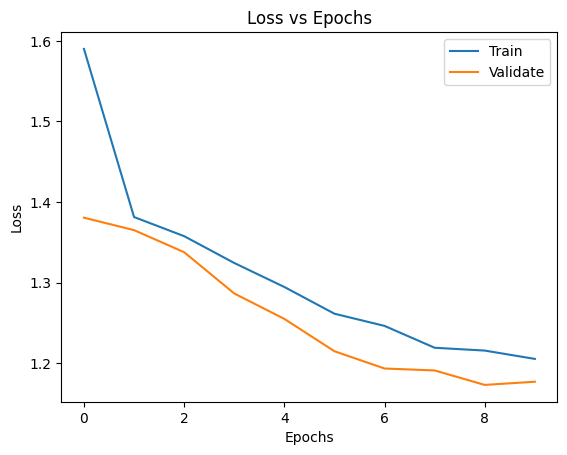

<Figure size 640x480 with 0 Axes>

In [ ]:
# metrics to evaluate my model
num_samples = 3
baseline_test_output = [np.array([]) for _ in range(num_samples)]
baseline_test_y = [np.array([]) for _ in range(num_samples)]
representations = pd.DataFrame()

test_patient_list = fetch_data.test_patient_list
num_batches_test = int(np.ceil(len(test_patient_list)/batch_size))
test_dataset, test_loader = get_data_and_loader(test_patient_list, fetch_data, model_type, batch_size, shuffle=False)

# Download model checkpoint
gdown.download('https://drive.google.com/uc?id=15w1eJRql0MzIBu5x4sxJYYS7hrXvRCO2')
checkpoint = torch.load('/content/baseline.pt')
model = Baseline(num_features_static, main_hidden_dim, dropout_rate)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
baseline_test_output = checkpoint['test_output']
baseline_test_y = checkpoint['test_y']
baseline_train_losses = checkpoint['train_losses']
baseline_valid_losses = checkpoint['valid_losses']

# report standard error for uncertainty
baseline_test_output_se = np.array(baseline_test_output).std(axis=0) / np.sqrt(num_samples)

# take average over all samples to get expected value
baseline_test_output = np.array(baseline_test_output).mean(axis=0)
baseline_test_y = np.array(baseline_test_y).mean(axis=0)

baseline_results = pd.DataFrame({'actual':baseline_test_y, 'pred_raw':baseline_test_output, 'pred_raw_se':baseline_test_output_se})
baseline_results['pred_binary'] = (baseline_results['pred_raw']>threshold).astype(int)
baseline_metric_results = calculate_metrics(baseline_results['actual'], baseline_results['pred_binary'], baseline_results['pred_raw'])
print(baseline_metric_results)

# plot figures to better show the results
plt.plot(baseline_train_losses, label='Train')
plt.plot(baseline_valid_losses, label='Validate')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.clf()


## Model comparison

# GraphConv Graph model
The GNN model using GraphConv layers for non-longitudinal data.

In [ ]:
# Declare data variables, loss function, and optimizer
model_type = 'graph'
pooling_method = 'target'
ratio = 0.5
gamma = 1
alpha = 1
beta = 1
delta = 1
fetch_data = DataFetch(model_type=model_type, featfile='featfiles/featfile_G1.csv', gnn_layer='graphconv', alt_featfile='featfiles/featfile_A2.csv')
train_patient_list = fetch_data.train_patient_list
validate_patient_list = fetch_data.validate_patient_list
num_features_static = len(fetch_data.static_features)
num_features_alt_static = len(fetch_data.alt_static_features)
num_samples_train_dataset = len(train_patient_list)
num_samples_valid_dataset = len(validate_patient_list)
num_samples_train_minority_class = fetch_data.num_samples_train_minority_class
num_samples_valid_minority_class = fetch_data.num_samples_valid_minority_class
num_samples_train_majority_class = fetch_data.num_samples_train_majority_class
num_samples_valid_majority_class = fetch_data.num_samples_valid_majority_class
model = GNN(num_features_static, num_features_alt_static, main_hidden_dim, 'graphconv', pooling_method, dropout_rate, ratio)

loss_func = WeightedBCELoss(num_samples_train_dataset, num_samples_train_minority_class, num_samples_train_majority_class)
valid_loss_func = WeightedBCELoss(num_samples_valid_dataset, num_samples_valid_minority_class, num_samples_valid_majority_class)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_dataset, train_loader = get_data_and_loader(train_patient_list, fetch_data, model_type, batch_size)
validate_dataset, validate_loader = get_data_and_loader(validate_patient_list, fetch_data, model_type, batch_size)
print('static_data: ', len(fetch_data.static_data))
print('label data: ', len(fetch_data.label_data))
print('True label: ', fetch_data.label_data.sum().item())
print('False label: ', len(fetch_data.label_data) -fetch_data.label_data.sum().item())
print('Train dataset: ', len(train_patient_list))
print('Validate dataset: ', len(validate_patient_list))
print('Test dataset: ', len(fetch_data.test_patient_list))

Using GraphConv layers
static_data:  150000
label data:  150000
True label:  57297.0
False label:  92703.0
Train dataset:  27565
Validate dataset:  3872
Test dataset:  7860


**Below training step is used to generate checkpoint file 'gnn-graphconv.pt'**

In [ ]:
# # compare you model with others
# num_epoch = 10
# # model training loop: it is better to print the training/validation losses during the training
# train_losses = []
# valid_losses = []
# separate_loss_terms = {'NN_train':[], 'target_train':[], 'family_train':[], 'lstm_train':[], 'NN_valid':[], 'target_valid':[], 'family_valid':[], 'lstm_valid':[]}
# for i in range(num_epoch):
#   model.train()
#   epoch_train_loss = []
#   separate_loss_terms_epoch = {'NN_train':[], 'target_train':[], 'family_train':[], 'lstm_train':[], 'NN_valid':[], 'target_valid':[], 'family_valid':[], 'lstm_valid':[]}

#   for train_batch in tqdm(train_loader, total=num_batches_train):
#     x_static_node, x_static_graph, y, edge_index, edge_weight, batch, target_index = train_batch.patient_x_static, train_batch.x, train_batch.y.unsqueeze(1), train_batch.edge_index, train_batch.edge_attr, train_batch.batch, train_batch.target_index
#     output, patient_output, family_output = model(x_static_node, x_static_graph, edge_index, edge_weight, batch, target_index)
#     # combined loss that considers the additive effect of patient and family effects
#     loss_term_NN = gamma * loss_func(output, y)
#     loss_term_target = alpha * loss_func(patient_output, y)
#     loss_term_family = beta * loss_func(family_output, y)
#     separate_loss_terms_epoch['NN_train'].append(loss_term_NN.item())
#     separate_loss_terms_epoch['target_train'].append(loss_term_target.item())
#     separate_loss_terms_epoch['family_train'].append(loss_term_family.item())
#     loss = loss_term_NN + loss_term_target + loss_term_family

#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()
#     epoch_train_loss.append(loss.item())

#   # eval on validset
#   model.eval()
#   epoch_valid_loss = []
#   valid_output = np.array([])
#   valid_y = np.array([])
#   for valid_batch in tqdm(validate_loader, total=num_batches_validate):
#     x_static_node, x_static_graph, y, edge_index, edge_weight, batch, target_index = train_batch.patient_x_static, train_batch.x, train_batch.y.unsqueeze(1), train_batch.edge_index, train_batch.edge_attr, train_batch.batch, train_batch.target_index
#     output, patient_output, family_output = model(x_static_node, x_static_graph, edge_index, edge_weight, batch, target_index)

#     valid_output = np.concatenate((valid_output, output.reshape(-1).detach().cpu().numpy()))
#     valid_y = np.concatenate((valid_y, y.reshape(-1).detach().cpu().numpy()))

#     # combined loss that considers the additive effect of patient and family effects
#     loss_term_NN = gamma * valid_loss_func(output, y)
#     loss_term_target = alpha * valid_loss_func(patient_output, y)
#     loss_term_family = beta * valid_loss_func(family_output, y)
#     separate_loss_terms_epoch['NN_train'].append(loss_term_NN.item())
#     separate_loss_terms_epoch['target_train'].append(loss_term_target.item())
#     separate_loss_terms_epoch['family_train'].append(loss_term_family.item())
#     loss = loss_term_NN + loss_term_target + loss_term_family
#     epoch_valid_loss.append(loss.item())

#   train_loss, valid_loss = np.mean(epoch_train_loss), np.mean(epoch_valid_loss)
#   train_losses.append(train_loss)
#   valid_losses.append(valid_loss)
#   print("Train Loss: %.2f, Validation Loss: %.2f" % (train_loss, valid_loss))

# fpr, tpr, thresholds = metrics.roc_curve(valid_y, valid_output)
# gmeans = np.sqrt(tpr * (1-fpr))
# ix = np.argmax(gmeans)
# threshold = thresholds[ix]

# # you don't need to re-run all other experiments, instead, you can directly refer the metrics/numbers in the paper

  0%|          | 0/111 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 16/16 [00:16<00:00,  1.03s/it]


Train Loss: 5.15, Validation Loss: 4.11


100%|██████████| 16/16 [00:22<00:00,  1.41s/it]


Train Loss: 4.16, Validation Loss: 4.54


100%|██████████| 16/16 [00:21<00:00,  1.36s/it]


Train Loss: 4.13, Validation Loss: 3.61


100%|██████████| 16/16 [00:16<00:00,  1.00s/it]


Train Loss: 4.12, Validation Loss: 4.17


100%|██████████| 16/16 [00:15<00:00,  1.02it/s]


Train Loss: 4.11, Validation Loss: 4.55


100%|██████████| 16/16 [00:15<00:00,  1.05it/s]


Train Loss: 4.10, Validation Loss: 4.41


100%|██████████| 16/16 [00:15<00:00,  1.05it/s]


Train Loss: 4.08, Validation Loss: 4.06


100%|██████████| 16/16 [00:15<00:00,  1.05it/s]


Train Loss: 4.06, Validation Loss: 5.85


100%|██████████| 16/16 [00:14<00:00,  1.07it/s]


Train Loss: 4.02, Validation Loss: 3.74


100%|██████████| 16/16 [00:14<00:00,  1.08it/s]

Train Loss: 4.01, Validation Loss: 4.36


Downloading...
From: https://drive.google.com/uc?id=1-2UuB6VQQpc_GyMf3ekwxweiZw6xGilc
To: /content/gnn-graphconv.pt
100%|██████████| 173k/173k [00:00<00:00, 5.46MB/s]


Using GraphConv layers
{'metric_auc_roc': 0.7293003627232143, 'metric_auc_prc': 0.2515448218910561, 'metric_f1': 0.35604770017035775, 'metric_recall': 0.7256944444444444, 'metric_mcc': 0.2429998335640261, 'metric_ts': 0.21658031088082902, 'metric_bss': -0.7315366824073593, 'true_negatives': 1115, 'false_positives': 677, 'false_negatives': 79, 'true_positives': 209}


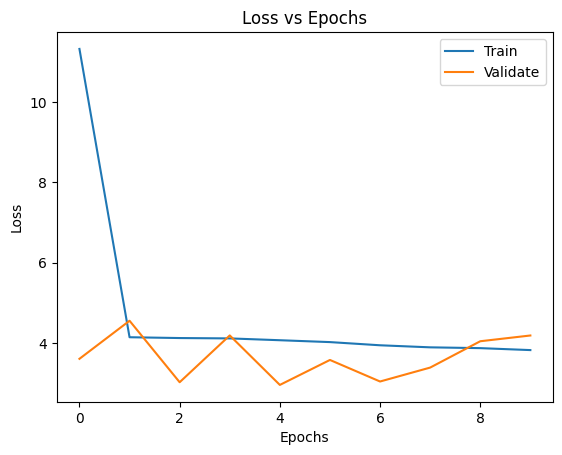

<Figure size 640x480 with 0 Axes>

In [94]:
# metrics to evaluate my model
num_samples = 3
gnn_graphconv_test_output = [np.array([]) for _ in range(num_samples)]
gnn_graphconv_test_y = [np.array([]) for _ in range(num_samples)]
representations = pd.DataFrame()

test_patient_list = fetch_data.test_patient_list
num_batches_test = int(np.ceil(len(test_patient_list)/batch_size))
test_dataset, test_loader = get_data_and_loader(test_patient_list, fetch_data, model_type, batch_size, shuffle=False)

gdown.download('https://drive.google.com/uc?id=1-2UuB6VQQpc_GyMf3ekwxweiZw6xGilc')
checkpoint = torch.load('/content/gnn-graphconv.pt')
model = GNN(num_features_static, num_features_alt_static, main_hidden_dim, 'graphconv', pooling_method, dropout_rate, ratio)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
gnn_graphconv_test_output = checkpoint['test_output']
gnn_graphconv_test_y = checkpoint['test_y']
gnn_graphconv_train_losses = checkpoint['train_losses']
gnn_graphconv_valid_losses = checkpoint['valid_losses']

# report standard error for uncertainty
gnn_graphconv_test_output_se = np.array(gnn_graphconv_test_output).std(axis=0) / np.sqrt(num_samples)

# take average over all samples to get expected value
gnn_graphconv_test_output = np.array(gnn_graphconv_test_output).mean(axis=0)
gnn_graphconv_test_y = np.array(gnn_graphconv_test_y).mean(axis=0)

gnn_graphconv_results = pd.DataFrame({'actual':gnn_graphconv_test_y, 'pred_raw':gnn_graphconv_test_output, 'pred_raw_se':gnn_graphconv_test_output_se})
gnn_graphconv_results['pred_binary'] = (gnn_graphconv_results['pred_raw']>threshold).astype(int)
gnn_graphconv_metric_results = calculate_metrics(gnn_graphconv_results['actual'], gnn_graphconv_results['pred_binary'], gnn_graphconv_results['pred_raw'])
print(gnn_graphconv_metric_results)

# plot figures to better show the results
plt.plot(gnn_graphconv_train_losses, label='Train')
plt.plot(gnn_graphconv_valid_losses, label='Validate')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.clf()
# it is better to save the numbers and figures for your presentation.

# GCN Graph Model

The GNN model using GCN layers for non-logitudinal data.

In [ ]:
# Declare data variables, loss function, and optimizer
model_type = 'graph'
pooling_method = 'target'
ratio = 0.5
gamma = 1
alpha = 1
beta = 1
delta = 1
fetch_data = DataFetch(model_type=model_type, featfile='featfiles/featfile_G1.csv', gnn_layer='graphconv', alt_featfile='featfiles/featfile_A2.csv')
train_patient_list = fetch_data.train_patient_list
validate_patient_list = fetch_data.validate_patient_list
num_features_static = len(fetch_data.static_features)
num_features_alt_static = len(fetch_data.alt_static_features)
num_samples_train_dataset = len(train_patient_list)
num_samples_valid_dataset = len(validate_patient_list)
num_samples_train_minority_class = fetch_data.num_samples_train_minority_class
num_samples_valid_minority_class = fetch_data.num_samples_valid_minority_class
num_samples_train_majority_class = fetch_data.num_samples_train_majority_class
num_samples_valid_majority_class = fetch_data.num_samples_valid_majority_class
model = GNN(num_features_static, num_features_alt_static, main_hidden_dim, 'gcn', pooling_method, dropout_rate, ratio)

loss_func = WeightedBCELoss(num_samples_train_dataset, num_samples_train_minority_class, num_samples_train_majority_class)
valid_loss_func = WeightedBCELoss(num_samples_valid_dataset, num_samples_valid_minority_class, num_samples_valid_majority_class)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_dataset, train_loader = get_data_and_loader(train_patient_list, fetch_data, model_type, batch_size)
validate_dataset, validate_loader = get_data_and_loader(validate_patient_list, fetch_data, model_type, batch_size)

Using GCN layers


**Below is the training step used to generate checkpoint file 'gnn-gcn.pt'**

In [ ]:
# # compare you model with others
# num_epoch = 10
# # model training loop: it is better to print the training/validation losses during the training
# train_losses = []
# valid_losses = []
# separate_loss_terms = {'NN_train':[], 'target_train':[], 'family_train':[], 'lstm_train':[], 'NN_valid':[], 'target_valid':[], 'family_valid':[], 'lstm_valid':[]}
# for i in range(num_epoch):
#   model.train()
#   epoch_train_loss = []
#   separate_loss_terms_epoch = {'NN_train':[], 'target_train':[], 'family_train':[], 'lstm_train':[], 'NN_valid':[], 'target_valid':[], 'family_valid':[], 'lstm_valid':[]}

#   for train_batch in tqdm(train_loader, total=num_batches_train):
#     x_static_node, x_static_graph, y, edge_index, edge_weight, batch, target_index = train_batch.patient_x_static, train_batch.x, train_batch.y.unsqueeze(1), train_batch.edge_index, train_batch.edge_attr, train_batch.batch, train_batch.target_index
#     output, patient_output, family_output = model(x_static_node, x_static_graph, edge_index, edge_weight, batch, target_index)
#     # combined loss that considers the additive effect of patient and family effects
#     loss_term_NN = gamma * loss_func(output, y)
#     loss_term_target = alpha * loss_func(patient_output, y)
#     loss_term_family = beta * loss_func(family_output, y)
#     separate_loss_terms_epoch['NN_train'].append(loss_term_NN.item())
#     separate_loss_terms_epoch['target_train'].append(loss_term_target.item())
#     separate_loss_terms_epoch['family_train'].append(loss_term_family.item())
#     loss = loss_term_NN + loss_term_target + loss_term_family

#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()
#     epoch_train_loss.append(loss.item())

#   # eval on validset
#   model.eval()
#   epoch_valid_loss = []
#   valid_output = np.array([])
#   valid_y = np.array([])
#   for valid_batch in tqdm(validate_loader, total=num_batches_validate):
#     x_static_node, x_static_graph, y, edge_index, edge_weight, batch, target_index = train_batch.patient_x_static, train_batch.x, train_batch.y.unsqueeze(1), train_batch.edge_index, train_batch.edge_attr, train_batch.batch, train_batch.target_index
#     output, patient_output, family_output = model(x_static_node, x_static_graph, edge_index, edge_weight, batch, target_index)

#     valid_output = np.concatenate((valid_output, output.reshape(-1).detach().cpu().numpy()))
#     valid_y = np.concatenate((valid_y, y.reshape(-1).detach().cpu().numpy()))

#     # combined loss that considers the additive effect of patient and family effects
#     loss_term_NN = gamma * valid_loss_func(output, y)
#     loss_term_target = alpha * valid_loss_func(patient_output, y)
#     loss_term_family = beta * valid_loss_func(family_output, y)
#     separate_loss_terms_epoch['NN_train'].append(loss_term_NN.item())
#     separate_loss_terms_epoch['target_train'].append(loss_term_target.item())
#     separate_loss_terms_epoch['family_train'].append(loss_term_family.item())
#     loss = loss_term_NN + loss_term_target + loss_term_family
#     epoch_valid_loss.append(loss.item())

#   train_loss, valid_loss = np.mean(epoch_train_loss), np.mean(epoch_valid_loss)
#   train_losses.append(train_loss)
#   valid_losses.append(valid_loss)
#   print("Train Loss: %.2f, Validation Loss: %.2f" % (train_loss, valid_loss))

# fpr, tpr, thresholds = metrics.roc_curve(valid_y, valid_output)
# gmeans = np.sqrt(tpr * (1-fpr))
# ix = np.argmax(gmeans)
# threshold = thresholds[ix]

# # metrics to evaluate my model
# num_samples = 3
# test_output = [np.array([]) for _ in range(num_samples)]
# test_y = [np.array([]) for _ in range(num_samples)]
# representations = pd.DataFrame()

# test_patient_list = fetch_data.test_patient_list
# num_batches_test = int(np.ceil(len(test_patient_list)/batch_size))
# test_dataset, test_loader = get_data_and_loader(test_patient_list, fetch_data, model_type, batch_size, shuffle=False)

# model.eval()
# for m in model.modules():
#   if m.__class__.__name__.startswith('Dropout'):
#     m.train()

# for sample in range(num_samples):
#     for test_batch in tqdm(test_loader, total=num_batches_test):
#         x_static_node, x_static_graph, y, edge_index, edge_weight, batch, target_index = train_batch.patient_x_static, train_batch.x, train_batch.y.unsqueeze(1), train_batch.edge_index, train_batch.edge_attr, train_batch.batch, train_batch.target_index
#         output, patient_output, family_output = model(x_static_node, x_static_graph, edge_index, edge_weight, batch, target_index)
#         test_output[sample] = np.concatenate((test_output[sample], output.reshape(-1).detach().cpu().numpy()))
#         test_y[sample] = np.concatenate((test_y[sample], y.reshape(-1).detach().cpu().numpy()))

# # you don't need to re-run all other experiments, instead, you can directly refer the metrics/numbers in the paper

  0%|          | 0/111 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 16/16 [00:15<00:00,  1.01it/s]


Train Loss: 4.83, Validation Loss: 3.86


100%|██████████| 16/16 [00:16<00:00,  1.03s/it]


Train Loss: 4.16, Validation Loss: 4.08


100%|██████████| 16/16 [00:18<00:00,  1.14s/it]


Train Loss: 4.16, Validation Loss: 3.85


100%|██████████| 16/16 [00:15<00:00,  1.02it/s]


Train Loss: 4.15, Validation Loss: 3.60


100%|██████████| 16/16 [00:15<00:00,  1.00it/s]


Train Loss: 4.15, Validation Loss: 4.31


100%|██████████| 16/16 [00:16<00:00,  1.01s/it]


Train Loss: 4.15, Validation Loss: 4.55


100%|██████████| 16/16 [00:17<00:00,  1.06s/it]


Train Loss: 4.14, Validation Loss: 4.30


100%|██████████| 16/16 [00:15<00:00,  1.01it/s]


Train Loss: 4.13, Validation Loss: 4.35


100%|██████████| 16/16 [00:15<00:00,  1.01it/s]


Train Loss: 4.12, Validation Loss: 3.06


100%|██████████| 16/16 [00:16<00:00,  1.02s/it]

Train Loss: 4.13, Validation Loss: 5.23


Downloading...
From: https://drive.google.com/uc?id=1-3ZZGCHYJbxOHWLE6SfEHSh2mfsblqW0
To: /content/gnn-gcn.pt
100%|██████████| 164k/164k [00:00<00:00, 4.99MB/s]


Using GCN layers
{'metric_auc_roc': 0.644297933343596, 'metric_auc_prc': 0.18219790139505848, 'metric_f1': 0.27489481065918653, 'metric_recall': 0.4375, 'metric_mcc': 0.1658164449111292, 'metric_ts': 0.15934959349593497, 'metric_bss': -0.5934418337328038, 'true_negatives': 1465, 'false_positives': 391, 'false_negatives': 126, 'true_positives': 98}


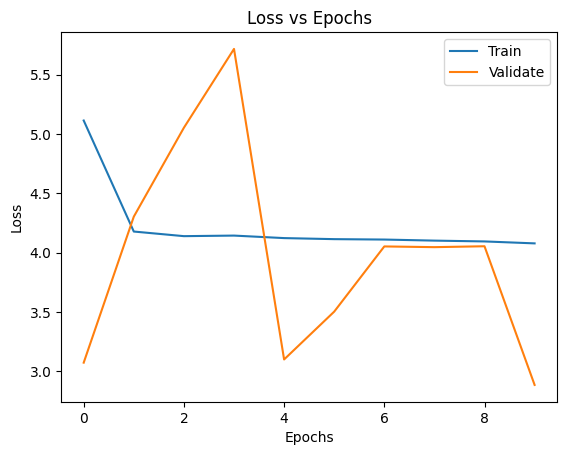

<Figure size 640x480 with 0 Axes>

In [ ]:
# metrics to evaluate my model
num_samples = 3
gnn_gcn_test_output = [np.array([]) for _ in range(num_samples)]
gnn_gcn_test_y = [np.array([]) for _ in range(num_samples)]
representations = pd.DataFrame()

test_patient_list = fetch_data.test_patient_list
num_batches_test = int(np.ceil(len(test_patient_list)/batch_size))
test_dataset, test_loader = get_data_and_loader(test_patient_list, fetch_data, model_type, batch_size, shuffle=False)

gdown.download('https://drive.google.com/uc?id=1-3ZZGCHYJbxOHWLE6SfEHSh2mfsblqW0')
checkpoint = torch.load('/content/gnn-gcn.pt')
model = GNN(num_features_static, num_features_alt_static, main_hidden_dim, 'gcn', pooling_method, dropout_rate, ratio)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
gnn_gcn_test_output = checkpoint['test_output']
gnn_gcn_test_y = checkpoint['test_y']
gnn_gcn_train_losses = checkpoint['train_losses']
gnn_gcn_valid_losses = checkpoint['valid_losses']

# report standard error for uncertainty
gnn_gcn_test_output_se = np.array(gnn_gcn_test_output).std(axis=0) / np.sqrt(num_samples)

# take average over all samples to get expected value
gnn_gcn_test_output = np.array(gnn_gcn_test_output).mean(axis=0)
gnn_gcn_test_y = np.array(gnn_gcn_test_y).mean(axis=0)

gnn_gcn_results = pd.DataFrame({'actual':gnn_gcn_test_y, 'pred_raw':gnn_gcn_test_output, 'pred_raw_se':gnn_gcn_test_output_se})
gnn_gcn_results['pred_binary'] = (gnn_gcn_results['pred_raw']>threshold).astype(int)
gnn_gcn_metric_results = calculate_metrics(gnn_gcn_results['actual'], gnn_gcn_results['pred_binary'], gnn_gcn_results['pred_raw'])
print(gnn_gcn_metric_results)

# plot figures to better show the results
plt.plot(train_losses, label='Train')
plt.plot(valid_losses, label='Validate')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.clf()
# it is better to save the numbers and figures for your presentation.

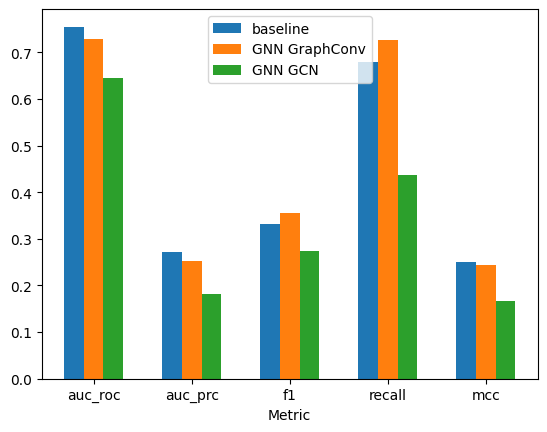

<Figure size 640x480 with 0 Axes>

In [95]:
X = ['auc_roc', 'auc_prc', 'f1', 'recall', 'mcc']
X_axis = np.arange(len(X))
plt.bar(X_axis-0.2, list(baseline_metric_results.values())[:5], 0.2, label='baseline')
plt.bar(X_axis, list(gnn_graphconv_metric_results.values())[:5], 0.2, label='GNN GraphConv')
plt.bar(X_axis+0.2, list(gnn_gcn_metric_results.values())[:5], 0.2, label='GNN GCN')
plt.legend()
plt.xticks(X_axis, X)
plt.xlabel('Metric')
plt.show()
plt.clf()

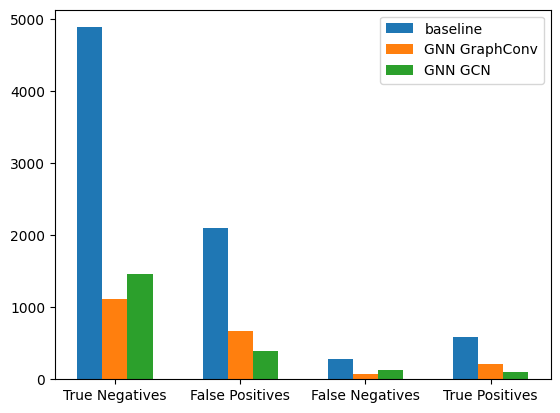

<Figure size 640x480 with 0 Axes>

In [96]:
X = ['True Negatives', 'False Positives', 'False Negatives', 'True Positives']
X_axis = np.arange(len(X))
plt.bar(X_axis-0.2, list(baseline_metric_results.values())[-4:], 0.2, label='baseline')
plt.bar(X_axis, list(gnn_graphconv_metric_results.values())[-4:], 0.2, label='GNN GraphConv')
plt.bar(X_axis+0.2, list(gnn_gcn_metric_results.values())[-4:], 0.2, label='GNN GCN')
plt.legend()
plt.xticks(X_axis, X)
plt.show()
plt.clf()

# Discussion

This paper is reproducible, and by following along with the paper itself, the related GitHub repository, and the synthetic data generator, we were able to replicate the paper's results. The authors made great efforts in making their work easily reproducible. Providing a synthetic data generator greatly simplified the process of replicating their work. Additionally, they provided a table comparing the results of their models to the baseline models, which made it simple to see if our work matched theirs.

The baseline model received a lower recall score than both of the graph-based models. The area under the curve for the baseline model is slightly higher than in the graph-based models. The F1 score for all three models is very similar, with the GraphConv graph model outperforming the other two models very slightly.


We also saw that the GraphConv GNN model performed better than the GCN model. This aligns with the hypothese we made above. Although the metrics are very similar, the higher auc_roc score and F1 score, with a very similar recall, show that the GraphConv model is slightly better.

In the next phase of the project, we will implement more of the ablations mentioned in the paper. For example, we would like to test various data features in the models. It would also be interesting to investigate different structures for the GNN model to see if we can improve the accuracy of the model.

In [ ]:
# no code is required for this section
'''
if you want to use an image outside this notebook for explanaition,
you can read and plot it here like the Scope of Reproducibility
'''

# References

1.   Sun, J, [paper title], [journal title], [year], [volume]:[issue], doi: [doi link to paper]



# Feel free to add new sections